In [2]:
import torch
from torch import nn
import torch.optim as optim

import torchtext
import pandas as pd
import numpy as np
import sklearn.metrics
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

from models import MLP1Base, MLP2Base, MetaMLPModel
from torchmeta.modules import MetaLinear
import scipy.stats

In [3]:
df=pd.read_csv('./parallelograms-revisited/experiment2_data_relational_similarity/mean_relsim_ratings.csv')

In [4]:
y = np.array(df['mean_rating'])

In [5]:
df

,relation1,relation2,comparison_type,pair1_word1,pair1_word2,pair2_word1,pair2_word2,mean_rating,num_ratings
0,3a,3a,within-subtype,candy,sweets,sofa,chair,3.750000,12
1,1a,1a,within-subtype,dollar,currency,wheat,bread,4.727273,11
2,9a,9a,within-subtype,store,shopper,supermarket,groceries,5.583333,12
3,6a,6a,within-subtype,classic,trendy,integrity,dishonest,3.700000,10
4,10a,10a,within-subtype,flashing,caution,green,go,6.583333,12
...,...,...,...,...,...,...,...,...,...
6189,8b,8a,between-subtype,embarrassed,blush,explosion,damage,5.200000,10
6190,1a,2a,between-type,animal,carabao,dog,tail,3.090909,11
6191,5a,7c,between-type,intellectual,professor,police,gun,3.200000,10
6192,8a,8a,within-subtype,education,expertise,showering,cleanliness,4.800000,10


In [6]:
vocab = torchtext.vocab.GloVe(name='840B', dim=300)

In [7]:
# meta_linear_params = torch.load('/n/fs/nlp-myhu/research-code/pytorch-maml/output/jan15_analogy/2021-01-15_091502linear/model.th', map_location=torch.device('cpu'))
# meta_mlp1_params = torch.load('/n/fs/nlp-myhu/research-code/pytorch-maml/output/jan15_analogy/2021-01-15_091502mlp1/model.th', map_location=torch.device('cpu'))
# meta_mlp2_params = torch.load('/n/fs/nlp-myhu/research-code/pytorch-maml/output/jan15_analogy/2021-01-15_091502mlp2/model.th', map_location=torch.device('cpu'))

meta_linear_params = torch.load('/n/fs/nlp-myhu/research-code/pytorch-maml/output/jan20_analogy/2021-01-20_093635linear/model.th', map_location=torch.device('cpu'))
meta_mlp1_params = torch.load('/n/fs/nlp-myhu/research-code/pytorch-maml/output/jan20_analogy/2021-01-20_093635mlp1/model.th', map_location=torch.device('cpu'))
meta_mlp2_params = torch.load('/n/fs/nlp-myhu/research-code/pytorch-maml/output/jan20_analogy/2021-01-20_093635mlp2/model.th', map_location=torch.device('cpu'))

In [8]:
meta_linear = nn.Linear(in_features=300, out_features=300)
meta_mlp1 = MLP1Base(input_dim=300, hidden_dim=500, output_dim=300)
meta_mlp2 = MLP2Base(input_dim=300, hidden_dim=500, output_dim=300)

In [9]:
meta_linear.weight.data = meta_linear_params['weight']
meta_linear.bias.data = meta_linear_params['bias']

meta_mlp1.l1.weight.data = meta_mlp1_params['features.layer1.linear.weight']
meta_mlp1.l1.bias.data = meta_mlp1_params['features.layer1.linear.bias']
meta_mlp1.l2.weight.data = meta_mlp1_params['classifier.weight']
meta_mlp1.l2.bias.data = meta_mlp1_params['classifier.bias']

meta_mlp2.l1.weight.data = meta_mlp2_params['features.layer1.linear.weight']
meta_mlp2.l1.bias.data = meta_mlp2_params['features.layer1.linear.bias']
meta_mlp2.l2.weight.data = meta_mlp2_params['features.layer2.linear.weight']
meta_mlp2.l2.bias.data = meta_mlp2_params['features.layer2.linear.bias']
meta_mlp2.l3.weight.data = meta_mlp2_params['classifier.weight']
meta_mlp2.l3.bias.data = meta_mlp2_params['classifier.bias']

In [10]:
def compute_alpha(df, vocab, get_loss):
    prediction_dict = []
    
    for idx, row in tqdm(df.iterrows()):
        w1, w2, w3, w4 = row['pair1_word1'], row['pair1_word2'], row['pair2_word1'], row['pair2_word2']

        if w1 not in vocab.stoi or w2 not in vocab.stoi or w3 not in vocab.stoi or w4 not in vocab.stoi:
            continue
            
        category_id = int(row['relation1'][:-1])
        human_score = (row['mean_rating'] - 1) / 6 + 1e-20
            
        a = vocab[w1]
        b = vocab[w2]
        c = vocab[w3]
        d = vocab[w4]
        
        forward = get_loss(a, b, c, d)

        prediction_dict.append(-np.log(human_score)/forward)
        
    return prediction_dict

In [11]:
def get_categorized_relsim_scores(df, vocab, get_loss, alpha=10):
    prediction_dict = defaultdict(lambda: [])
    word_dict = defaultdict(lambda: [])
    
    for idx, row in tqdm(df.iterrows()):
        w1, w2, w3, w4 = row['pair1_word1'], row['pair1_word2'], row['pair2_word1'], row['pair2_word2']

        if w1 not in vocab.stoi or w2 not in vocab.stoi or w3 not in vocab.stoi or w4 not in vocab.stoi:
            continue
            
        category_id = int(row['relation1'][:-1])
        human_score = row['mean_rating']
        word_dict[category_id].append(human_score)
            
        a = vocab[w1]
        b = vocab[w2]
        c = vocab[w3]
        d = vocab[w4]
        
        forward = get_loss(a, b, c, d)
        backward = get_loss(c, d, a, b)

        prediction_dict[category_id].append(np.exp(-alpha * forward))
        
    return prediction_dict, word_dict

In [12]:
def get_categorized_relsim_scores_cos(df, vocab, get_loss):
    prediction_dict = defaultdict(lambda: [])
    word_dict = defaultdict(lambda: [])
    
    for idx, row in tqdm(df.iterrows()):
        w1, w2, w3, w4 = row['pair1_word1'], row['pair1_word2'], row['pair2_word1'], row['pair2_word2']

        if w1 not in vocab.stoi or w2 not in vocab.stoi or w3 not in vocab.stoi or w4 not in vocab.stoi:
            continue
            
        category_id = int(row['relation1'][:-1])
        human_score = row['mean_rating']
        word_dict[category_id].append(human_score)
            
        a = vocab[w1]
        b = vocab[w2]
        c = vocab[w3]
        d = vocab[w4]
        
        loss = get_loss(a, b, c, d)[0][0]
        # print(loss)

        prediction_dict[category_id].append(loss)
        
    return prediction_dict, word_dict

In [13]:
def get_categorized_relsim_scores_eu(df, vocab, get_loss):
    prediction_dict = defaultdict(lambda: [])
    word_dict = defaultdict(lambda: [])
    
    for idx, row in tqdm(df.iterrows()):
        w1, w2, w3, w4 = row['pair1_word1'], row['pair1_word2'], row['pair2_word1'], row['pair2_word2']

        if w1 not in vocab.stoi or w2 not in vocab.stoi or w3 not in vocab.stoi or w4 not in vocab.stoi:
            continue
            
        category_id = int(row['relation1'][:-1])
        human_score = row['mean_rating']
        word_dict[category_id].append(human_score)
            
        a = vocab[w1]
        b = vocab[w2]
        c = vocab[w3]
        d = vocab[w4]
        
        loss = get_loss(a, b, c, d)
        # print(loss)

        prediction_dict[category_id].append(loss)
        
    return prediction_dict, word_dict

In [14]:
mlopt = optim.SGD(meta_linear.parameters(), lr=0.1)
mm1opt = optim.SGD(meta_mlp1.parameters(), lr=0.1)
mm2opt = optim.SGD(meta_mlp2.parameters(), lr=0.1)

mlcache = meta_linear.state_dict()
mm1cache = meta_mlp1.state_dict()
mm2cache = meta_mlp2.state_dict()

criterion = nn.MSELoss()

def get_ml_loss(a, b, c, d):
    meta_linear.load_state_dict(mlcache)
    mlopt.zero_grad()
    a_hat = meta_linear(a)
    loss = criterion(a_hat, b)
    loss.backward()
    mlopt.step()
    c_hat = meta_linear(c)
    loss = criterion(c_hat, d)
    return loss.detach().numpy()

def get_m1_loss(a, b, c, d):
    meta_mlp1.load_state_dict(mm1cache)
    mm1opt.zero_grad()
    a_hat = meta_mlp1(a)
    loss = criterion(a_hat, b)
    loss.backward()
    mm1opt.step()
    c_hat = meta_mlp1(c)
    loss = criterion(c_hat, d)
    return loss.detach().numpy()

def get_m2_loss(a, b, c, d):
    meta_mlp2.load_state_dict(mm2cache)
    mm2opt.zero_grad()
    a_hat = meta_mlp2(a)
    loss = criterion(a_hat, b)
    loss.backward()
    mm2opt.step()
    c_hat = meta_mlp2(c)
    loss = criterion(c_hat, d)
    return loss.detach().numpy()

def cos(a, b, c, d):
    return sklearn.metrics.pairwise.cosine_similarity((a-b).reshape(1, -1), c-d.reshape(1, -1))

def euclid(a, b, c, d):
    r1 = a-b
    r2 = c-d
    return 1-np.linalg.norm(r1-r2)

In [ ]:
scipy.stats.ttest_1samp(x_mlp2, 0)

In [ ]:
plt.hist(x_mlp2)

In [ ]:
for key, val in m2_pred_dict.items():
    print(key, scipy.stats.ttest_1samp(val, 0))

In [39]:
m2_pred_dict, m2_word_dict = get_categorized_relsim_scores(df, vocab, get_m2_loss, alpha=1)

6194it [00:40, 152.79it/s]


In [15]:
alphas = compute_alpha(df, vocab, get_m2_loss)
np.mean(alphas)

6194it [00:24, 251.18it/s]


7.360320991824765

In [ ]:
plt.hist(alphas)

In [17]:
cos_pred, word_dict = get_categorized_relsim_scores_cos(df, vocab, cos)

6194it [00:03, 1993.93it/s]


In [18]:
eu_predict, word_dict = get_categorized_relsim_scores_eu(df, vocab, euclid)

6194it [00:01, 6110.38it/s]


In [21]:
def get_category_coeffs(word_dict, pred_dict):
    r_list = [0] * (len(word_dict)+1)

    for key, val in word_dict.items():
        # val = np.array(val)
        # normalized_val = (val - 1) / 6 
        pred = pred_dict[key]
        # pred = np.exp(np.array(pred))
        corr, pval = scipy.stats.pearsonr(val, pred)
        r_list[key] = corr
        
    return r_list[1:]

In [29]:
def get_all_preds(cos_dict, pred_dict):
    all_cos_preds = []
    all_my_preds = []
    for key, val in cos_dict.items():
        all_cos_preds += val
        all_my_preds += pred_dict[key]
        
    return all_cos_preds, all_my_preds

In [37]:
all_cos, all_m2 = get_all_preds(word_dict, m2_pred_dict)
scipy.stats.pearsonr(all_cos, all_m2)

(0.09898973312207526, 5.7965350232696985e-15)

In [22]:
cos_corr = get_category_coeffs(word_dict, cos_pred)
eu_corr = get_category_coeffs(word_dict, eu_predict)
meta_corr = get_category_coeffs(word_dict, m2_pred_dict)

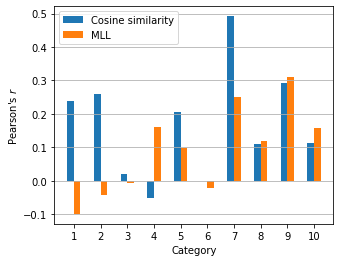

In [40]:
N = 10

fig, ax = plt.subplots(figsize=(5, 4))
ind = np.arange(10)
width = 0.25
p1 = ax.bar(ind, cos_corr, width)
# p2 = ax.bar(ind+width, eu_corr, width)
p3 = ax.bar(ind+width, meta_corr, width)

# ax.set_title("Pearson's $r$ by category")
ax.set_xlabel('Category')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((1, 2, 3, 4, 5, 6, 7, 8, 9, 10))
ax.grid(axis='y')

ax.legend((p1[0], p3[0]), ('Cosine similarity',
                                 'MLL'))
ax.set_ylabel("Pearson's $r$")
ax.autoscale_view()

In [ ]:
m2_pred_dict[3][:10]

In [ ]:
vals = np.array(word_dict[3][:10])
(vals-1)/6